<a href="https://colab.research.google.com/github/MonaaMohammed/SeeAPP-/blob/master/selecting_the_objects_SeeApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.16 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (3925/3925), done.


In [2]:
!ls

darknet  sample_data


In [3]:
cd darknet

/content/darknet


In [4]:
!ls

cfg	  include	LICENSE.gen   LICENSE.mit  python     src
data	  LICENSE	LICENSE.gpl   LICENSE.v1   README.md
examples  LICENSE.fuck	LICENSE.meta  Makefile	   scripts


In [0]:
!sed -i 's/GPU=0/GPU=1/g' Makefile

In [6]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/utils.c -o obj/utils.o


In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2019-07-28 14:28:39--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  98.0MB/s    in 2.4s    

2019-07-28 14:28:42 (98.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [8]:
!pip install opencv-python

In [9]:
!pip list

Package                  Version              
------------------------ ---------------------
absl-py                  0.7.1                
alabaster                0.7.12               
albumentations           0.1.12               
altair                   3.1.0                
astor                    0.8.0                
astropy                  3.0.5                
atari-py                 0.1.15               
atomicwrites             1.3.0                
attrs                    19.1.0               
audioread                2.1.8                
autograd                 1.2                  
Babel                    2.7.0                
backcall                 0.1.0                
backports.tempfile       1.0                  
backports.weakref        1.0.post1            
beautifulsoup4           4.6.3                
bleach                   3.1.0                
blis                     0.2.4                
bokeh                    1.0.4                
boto         

In [10]:
import numpy as np
import time
import cv2
import os
import imutils
import subprocess
!pip install pydub

[INFO] loading YOLO from disk...
10.92896174863388
person infom
['person the center']


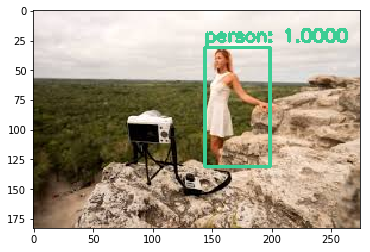

In [19]:
# load the COCO class labels our YOLO model was trained on
LABELS = open("/content/darknet/data/coco.names").read().strip().split("\n")

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet("/content/darknet/cfg/yolov3.cfg", "/content/darknet/yolov3.weights")

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize
# load the image with imread()


imageSource =  '/content/images (1).jpg'


dic_minper = dict(classID = 0 ,minper = 3.1 )
dic_maxper = dict(classID =0  , maxper = 12.1 )
#minPer = 3.1
#maxPer = 12.1

img = cv2.imread(imageSource)

COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

# grab the image dimensions and convert it to a blob
(H, W) = img.shape[:2]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
swapRB=True, crop=False)
net.setInput(blob)
layerOutputs = net.forward(ln)

# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []
centers = []
detected= []

 
# combian the data 
dic_minper = dict(classID = 0 ,minper = 3.1 )
dic_maxper = dict(classID = 0 ,maxper = 12.1 )
# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
      # extract the class ID and confidence (i.e., probability) of
      # the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
      

      # filter out weak predictions by ensuring the detected
      # probability is greater than the minimum probability
      if confidence > 0.5:
          # scale the bounding box coordinates back relative to the
          # size of the image, keeping in mind that YOLO actually
          # returns the center (x, y)-coordinates of the bounding
          # box followed by the boxes' width and height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # use the center (x, y)-coordinates to derive the top and
          # and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))

          # update our list of bounding box coordinates, confidences,
          # and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)
          
          centers.append((centerX, centerY))
          if classID == 0:
            spacePer = (width * height) /(img.shape[0] * img.shape[1]) * 100  
            print(spacePer)
           
               
          
           
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
  texts =[]
  classes_In_center =[]
  
  b=set()
  texts_of_3objects=[]
# ensure at least one detection exists
if len(idxs) > 0: 
      
          
    # loop over the indexes we are keeping
  for i in idxs.flatten():
          centerX, centerY = centers[i][0], centers[i][1]
           
          

 
          
            #warning area
          if spacePer > dic_maxper["maxper"]:  
                 

                 # selecting objects in the warning area
            
                  print(" warning  sound !!")
                  print(LABELS[classIDs[i]] , "warn")
                  #selecting object based on path of the blind person in the center
                          #center
                  if  centerX <= (W/3 * 2):
                      W_pos = "center"
                      #here all the classes in the center 
                      classes_In_center.append(classIDs[i])
                      num_classes = len(classes_In_center)
                      #this remove the the duplicate classes in the list # classes_In_center=[]
                      for x in classes_In_center :
                        if x not in b :
                          texts.append(LABELS[classIDs[i]] +  W_pos )
                          b.add(x)
                      
                         
                        
                        
                    
                  #selecting object based on more dangers in the left
                          #left                                                          
                  elif centerX <= W/3 :
                      W_pos = "left"
                            #chair         #car                #bus
                      if( classID == 56 or classID == 2 or  classID == 5):
                         texts.append("there is "+   LABELS[classIDs[i]] + "in" + W_pos )   
                  #selecting object based on more dangers in the right
                  else:
                      W_pos = "right"
                           #chair         #car                #bus
                      if( classID == 56 or classID == 2 or  classID == 5):
                        texts.append("there is "+ LABELS[classIDs[i]] + "in" + W_pos )
                   
                 
            #informing area
          elif spacePer >= dic_minper["minper"] and spacePer <= dic_maxper["maxper"]:
              #selecting objects in the infoming area 
                  print (LABELS[classIDs[i]] , "infom")
                
                  
                  if centerX <= (W/3 * 2):
                        W_pos= " the center"
                       #here all the classes in the center 
                        classes_In_center.append(classIDs[i])
                        num_classes = len(classes_In_center)
                         #this remove the the duplicate classes in the list # classes_In_center=[]
                        for x in classes_In_center :
                            if x not in b :
                              texts.append(LABELS[classIDs[i]] +  W_pos )
                              b.add(x)
                       
                              
                                
                          
                        
                      
                        #texts.append("there is "+ LABELS[classIDs[i]]   +  "in"  + W_pos  )
                    #   print(texts)
                    #selecting object based on more dangers in the left  
                          #left                                                          
                  elif centerX <= W/3 :
                        W_pos = "left"
                            #chair         #car                #bus
                        if( classID == 56 or classID == 2 or  classID == 5):
                          texts.append("there is "+   LABELS[classIDs[i]] + "in" + W_pos )   
                       
                  else:
                        W_pos = "right"
                           #chair            #car                #bus
                        if( classID == 56 or classID == 2 or  classID == 5):
                          texts.append( W_pos + LABELS[classIDs[i]])
               
                     
         # print(texts)
          else:
                  print (LABELS[classIDs[i]], "Far")
              
   
  print(texts)
  
    
    
  
 

  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
            
if len(idxs) > 0:
			# loop over the indexes we are keeping
			for i in idxs.flatten():
				# extract the bounding box coordinates
				(x, y) = (boxes[i][0], boxes[i][1])
				(w, h) = (boxes[i][2], boxes[i][3])

				# draw a bounding box rectangle and label on the frame
				color = [int(c) for c in COLORS[classIDs[i]]]
				cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
				text = "{}: {:.4f}".format(LABELS[classIDs[i]],confidences[i])
				cv2.putText(img, text, (x, y - 5),
			  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2) 
label = LABELS[classIDs[i]]
if label not in detected:
  # find positions
  centerX, centerY = centers[i][0], centers[i][1]

  if centerX <= W/3:
    W_pos = "left "
  elif centerX <= (W/3 * 2):
    W_pos = "center "
  else:
    W_pos = "right "

  if centerY <= H/3:
    H_pos = "top "
  elif centerY <= (H/3 * 2):
    H_pos = "mid "
  else:
    H_pos = "bottom "
  texts.append(H_pos + W_pos + label)
#print(texts)
  detected.append(label)
  import matplotlib.pyplot as plt
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)
